In [2]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\annek\AppData\Local\Temp\ipykernel_19724\33350407.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


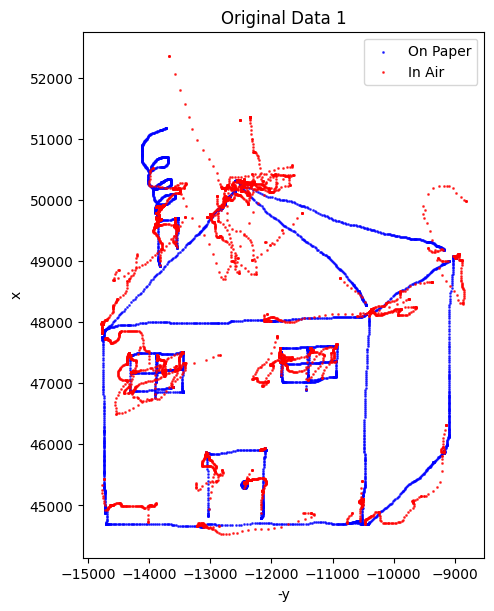

Processed data shape: (8461, 3)
Average number of data points: 8461


In [3]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler(feature_range=(-1, 1))  # Keep range (-1, 1)
        normalized_data = scaler.fit_transform(df[['x', 'y']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points


directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [4]:
#Cell 3
# Modify the LSTMDiscriminator
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self, seq_length=100):
        super(LSTMDiscriminator, self).__init__()
        self.seq_length = seq_length
        self.lstm1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(64)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = tf.reshape(x, (-1, self.seq_length, 3))
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dense1(x)
        return self.dense2(x)

# Modify the VAEGAN class
class VAEGAN(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, seq_length=100):
        super(VAEGAN, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.seq_length = seq_length
        
        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(seq_length, 3)),
            tf.keras.layers.LSTM(256, return_sequences=True),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(64 * seq_length),
            tf.keras.layers.Reshape((seq_length, 64)),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.LSTM(256, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3, activation='tanh'))
        ])
        
        # Discriminator
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(seq_length, 3)),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy = tf.clip_by_value(decoded[:, :, :2], -1, 1)
        pen_status = tf.round(tf.sigmoid(decoded[:, :, 2]))
        return tf.concat([xy, tf.expand_dims(pen_status, -1)], axis=-1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar


In [5]:
# Cell 4
# Loss function
def compute_loss(vaegan, x):
    x_reconstructed, mean, logvar = vaegan(x)
    
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))
    kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
    kl_loss = tf.reduce_mean(kl_loss)

    real_output = vaegan.discriminator(x)
    fake_output = vaegan.discriminator(x_reconstructed)
    
    d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
    d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
    g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

    vae_loss = reconstruction_loss + vaegan.beta * kl_loss
    d_loss = d_loss_real + d_loss_fake
    total_loss = vae_loss + g_loss + d_loss

    return total_loss, vae_loss, kl_loss, g_loss, d_loss

# Hyperparameters
latent_dim = 32  # Reduced from 256
beta = 1  # Increased from 0.001
learning_rate = 0.001  # Slightly reduced
seq_length = avg_data_points-1  # Increased from 50

vaegan = VAEGAN(latent_dim, beta, seq_length)
optimizer = tf.keras.optimizers.Adam(learning_rate)

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [6]:
# Cell 5 (modified)
def generate_augmented_data_vaegan(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        # Generate random latent vectors
        z = tf.random.normal((avg_data_points // model.seq_length, model.latent_dim))
        # Decode to generate augmented data
        augmented_data = model.decode(z).numpy()

        # Flatten the sequence dimension
        augmented_data = augmented_data.reshape(-1, 3)

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of data points
        if num_points < augmented_data.shape[0]:
            augmented_datasets.append(augmented_data[:num_points])
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_datasets.append(np.vstack([augmented_data, padding]))

    return augmented_datasets


In [7]:
# Cell 6 (modified)
def pad_sequences(data, target_length):
    """Pad sequences to target length."""
    current_length = data.shape[0]
    if current_length >= target_length:
        return data[:target_length]
    else:
        padding = np.zeros((target_length - current_length, data.shape[1]))
        return np.vstack([data, padding])

def create_sequences(data, seq_length):
    """Create sequences from data."""
    sequences = []
    for i in range(0, len(data) - seq_length + 1, seq_length):
        seq = data[i:i+seq_length]
        if len(seq) == seq_length:
            sequences.append(seq)
    return np.array(sequences)

@tf.function
def train_step(vaegan, x, optimizer):
    with tf.GradientTape() as tape:
        total_loss, vae_loss, kl_loss, g_loss, d_loss = compute_loss(vaegan, x)
    gradients = tape.gradient(total_loss, vaegan.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vaegan.trainable_variables))
    return total_loss, vae_loss, kl_loss, g_loss, d_loss

batch_size = 512
seq_length = avg_data_points-1

# Prepare data
sequences = create_sequences(combined_data, seq_length)
train_dataset = tf.data.Dataset.from_tensor_slices(sequences).shuffle(10000).batch(batch_size)

# Training loop
epochs = 1000
early_stopping_patience = 100
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

loss_history = {'total': [], 'vae': [], 'kl': [], 'g': [], 'd': []}

for epoch in range(epochs):
    epoch_losses = {'total': 0, 'vae': 0, 'kl': 0, 'g': 0, 'd': 0}
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            losses = train_step(vaegan, batch, optimizer)
            for key, value in zip(['total', 'vae', 'kl', 'g', 'd'], losses):
                epoch_losses[key] += value
            pbar.update(1)
            pbar.set_postfix({k: float(v) for k, v in zip(['Total', 'VAE', 'KL', 'G', 'D'], losses)})

    # Calculate average losses
    avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}
    for k, v in avg_losses.items():
        loss_history[k].append(v)

    print(f'Epoch {epoch+1}/{epochs}: ' + ', '.join([f'{k.capitalize()} Loss: {v:.4f}' for k, v in avg_losses.items()]))

    # Early stopping
    if avg_losses['total'] < best_loss - min_delta:
        best_loss = avg_losses['total']
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

    # Generate and visualize samples every 10 epochs
    if (epoch + 1) % 1 == 0:
        # Generate augmented data using VAEGAN
        num_augmented_files = 2
        augmented_datasets_vaegan = generate_augmented_data_vaegan(vaegan, num_augmented_files, avg_data_points)

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6 * (num_augmented_files + 1), 6))
        original_on_paper = combined_data[combined_data[:, 2] == 1]
        original_in_air = combined_data[combined_data[:, 2] == 0]
        # axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
        # axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
        # axs[0].set_xlabel('x')
        # axs[0].set_ylabel('y')
        # axs[0].set_aspect('equal')
        # axs[0].legend()

        # Set consistent axis limits for square aspect ratio
        x_min, x_max = -1, 1  # Set to -1 and 1 due to new scaling
        y_min, y_max = -1, 1  # Set to -1 and 1 due to new scaling

        for i, augmented_data in enumerate(augmented_datasets_vaegan):
            augmented_on_paper = augmented_data[augmented_data[:, 2] > 0.5]
            augmented_in_air = augmented_data[augmented_data[:, 2] <= 0.5]
            axs[i + 1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i + 1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i + 1].set_title(f'Augmented Data {i + 1}')
            axs[i + 1].set_xlabel('x')
            axs[i + 1].set_ylabel('y')
            axs[i + 1].set_aspect('equal')
            axs[i + 1].set_xlim(x_min, x_max)
            axs[i + 1].set_ylim(y_min, y_max)
            axs[i + 1].legend()

        plt.tight_layout()
        plt.show()

# Plot loss history
plt.figure(figsize=(12, 8))
for key, values in loss_history.items():
    plt.plot(values, label=key.capitalize())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

Epoch 1/1000:   0%|          | 0/1 [00:00<?, ?batch/s]

In [51]:
# Cell 7 (modified)
def download_augmented_data(augmented_datasets, scalers, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler) in enumerate(zip(augmented_datasets, scalers)):
        # Inverse transform the x and y coordinates
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :2]),
            augmented_data[:, 2]
        ))
        
        # Round to whole numbers and ensure pen_status is binary
        augmented_data_original_scale[:, :2] = np.round(augmented_data_original_scale[:, :2])
        augmented_data_original_scale[:, 2] = np.round(augmented_data_original_scale[:, 2]).astype(int)
        
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

download_augmented_data(augmented_datasets_vaegan, scalers[:len(augmented_datasets_vaegan)])

Saved augmented_data\augmented_data_1.csv
